# 5DEEP - Projet final : Classification des chants d'oiseaux

Pour rappel:

Il s'agit d'un problème de classification de chants d'oiseaux avec 5 classes, une pour chacune des espèces suivantes : 

- Bewick's Wren
- Northern Cardinal
- American Robin
- Song Sparrow
- Northern Mockingbird

Pour répondre à cette problématique, nous utiliserons des réseaux de neuronnes que nous préparerons et entraînerons grâce à Keras et Librosa dans ce notebook Jupyter.

## Etape 1: Analyse exploratoire et comprehension des données

Nous allons tout d'abord commencer par comprendre les différentes données mises à disposition, mais aussi comprendre l'interpretation de ces fichiers audio et leur traitement.

In [46]:
import pandas as pd

bird_df = pd.read_csv("data/bird_songs_metadata.csv")

bird_df.head(10)

bird_df.info()
bird_df.isnull().sum()

print("Nombre d'observations:", len(bird_df))

# On retire 'subspecies' car trop corrélée avec 'species' et pas de sens pour notre classification
# 'recordist', 'license', 'remarks', 'source_url' n'apporte pas de sens pour notre classificiation

# On conserve le 'filename' pour retrouver l'enregistrement associé


# est-ce qu'on garde 'sound_type' ?? On filtre ceux qui ne sont pas 'song'

# Notre variable cilble est 'species'

bird_df_song_only = bird_df[bird_df['sound_type'].str.contains("song", case=False, na=False)]

cols = ["id", "genus", "species", "name", "country", "location", 
        "latitude", "longitude", "altitude", "time", "date", "filename", 'sound_type']
bird_df_useful = bird_df_song_only[cols]

bird_df_useful.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
Nombre d

,id,genus,species,name,country,location,latitude,longitude,altitude,time,date,filename,sound_type
0,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-0.wav,"adult, sex uncertain, song"
1,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-1.wav,"adult, sex uncertain, song"
2,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-4.wav,"adult, sex uncertain, song"
3,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-5.wav,"adult, sex uncertain, song"
4,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-6.wav,"adult, sex uncertain, song"
5,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-8.wav,"adult, sex uncertain, song"
6,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-9.wav,"adult, sex uncertain, song"
7,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-11.wav,"adult, sex uncertain, song"
8,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-14.wav,"adult, sex uncertain, song"
9,557838,Thryomanes,bewickii,Bewick's Wren,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,11:51,2020-03-14,557838-15.wav,"adult, sex uncertain, song"


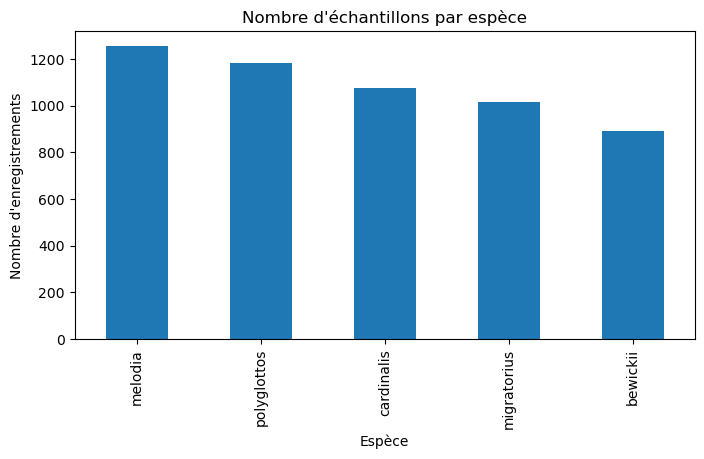

In [47]:
## Distribution & corrélations

import matplotlib.pyplot as plt

bird_df_useful['species'].value_counts().plot(kind='bar', figsize=(8,4))
plt.title("Nombre d'échantillons par espèce")
plt.xlabel("Espèce")
plt.ylabel("Nombre d'enregistrements")
plt.show()


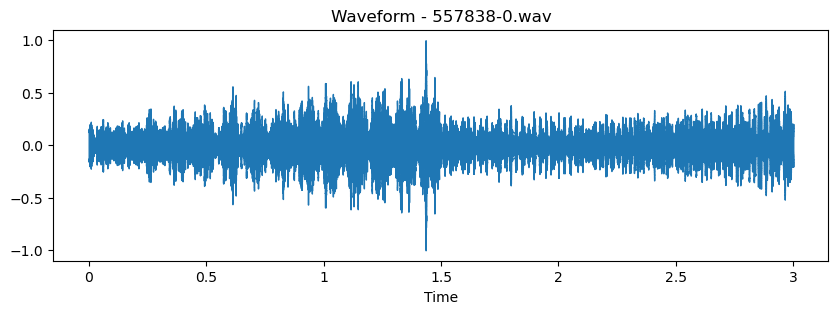

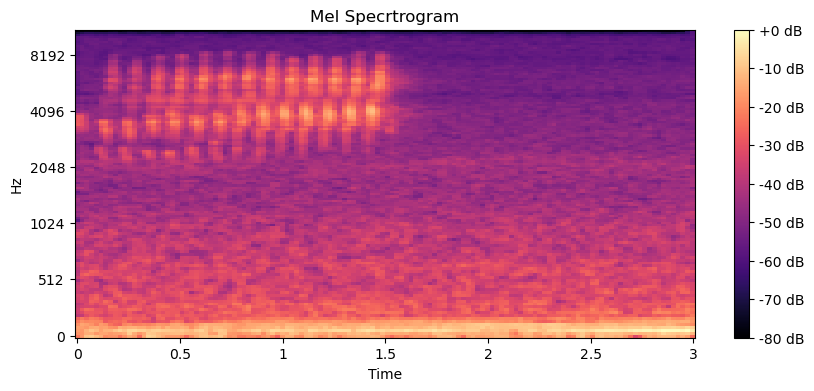

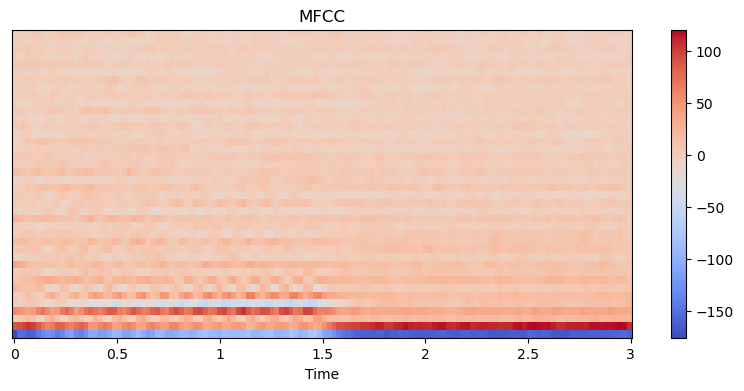

In [48]:
## Test librosa

import librosa
import librosa.display
import numpy as np

sample_file = bird_df_useful['filename'].iloc[0]
path = f"data/wavfiles/{sample_file}"
y, sr = librosa.load(path, sr=22050, mono=True)

# forme du signal
plt.figure(figsize=(10,3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - {sample_file}")
plt.show()

# mel spectrogram
def extract_mel_spectrogram(file_path, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    return log_mel.T # shape (time, n_mels)

# mfcc 
def extract_mfcc(file_path, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc.T  # shape (time, n_mfcc)


# test de la fonction mel spectrogram sur le sample
mel_spec = extract_mel_spectrogram(f"data/wavfiles/{sample_file}")
plt.figure(figsize=(10,4))
librosa.display.specshow(mel_spec.T, sr=sr, hop_length=512,
                            x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Specrtrogram")
plt.show()

# test de la fonction mfcc sur le sample
mfcc_feat = extract_mfcc(f"data/wavfiles/{sample_file}")
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc_feat.T, sr=sr, hop_length=512,
                            x_axis="time")
plt.colorbar()
plt.title("MFCC")
plt.show()


## Encoding & Sépération des différents datasets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


labels = bird_df_useful['name'].values
encoder = LabelEncoder()
y_int = encoder.fit_transform(labels)
y = to_categorical(y_int)
print("content de y :", y[10:])
print("Shape de y :", y.shape)

# on recup pour le moment juste les filenames, on constuira notre set de features plus tard
# grace à librosa
X = bird_df_useful['filename'].values

# 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train :", len(X_train), "Validation :", len(X_val), "Test :", len(X_test))


content de y : [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Shape de y : (5422, 5)
Train : 3795 Validation : 813 Test : 814


## Encoding et pré-traitement

In [ ]:
## Pré-traitement des données audio

# reucp la durée des enregistrements
durations = []
for f in bird_df_useful['filename']:
    y, sr = librosa.load(f"data/wavfiles/{f}", sr=None)
    durations.append(librosa.get_duration(y=y, sr=sr))
bird_df_useful['duration'] = durations


def prepare_dataset(file_list, base_path="data/wavfiles/"):
    features = []
    for f in file_list:
        path = base_path + f
        mel_spec = extract_mel_spectrogram(path)
        features.append(mel_spec)
    return features

# Exemple pour le train
X_train_features = prepare_dataset(X_train)



C:\Users\adrie\AppData\Local\Temp\ipykernel_16720\3803013614.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_df_useful['duration'] = durations
